<a href="https://colab.research.google.com/github/beezow526/midoribon/blob/main/Chap6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import binom
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

%matplotlib inline
sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [44]:
data = pd.read_csv('/content/Lesson12-1.csv')

In [45]:
data.head()

,N,y,x,f
0,8,1,9.76,C
1,8,6,10.48,C
2,8,5,10.83,C
3,8,6,10.94,C
4,8,1,9.37,C


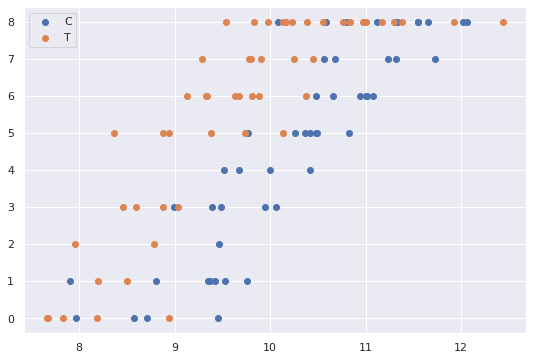

In [46]:
data_C = data.query('f == "C"')
data_T = data.query('f == "T"')

fig, ax = plt.subplots(figsize=(9,6))

plt.scatter(data_C['x'],data_C['y'],label='C')
plt.scatter(data_T['x'],data_T['y'],label='T')

plt.legend()


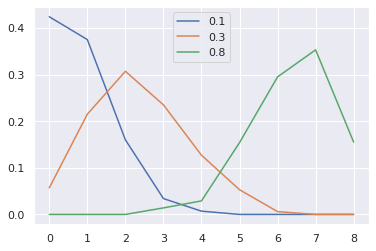

In [10]:
q_list = [0.1,0.3,0.8]
p_dicts =dict()
for q in q_list:
    p_dict = dict()
    for i in range(0,9):
        p_dict.update({i:0})
    for _ in range(1000):
        rnd = np.random.binomial(8,p=q)
        p_dict[rnd] += 1
    
    for i in range(0,9):
        p_dict[i] /= 1000
        
    p_dicts.update({q: p_dict})

for param,dictionary in p_dicts.items():
    plt.plot(list(dictionary.keys()),list(dictionary.values()),label=str(param))
    
plt.legend()


In [11]:
def sigmoid(x):
  return 1 / (1+np.exp(-x))

x = np.arange(-6,6,0.1)
y = sigmoid(x)

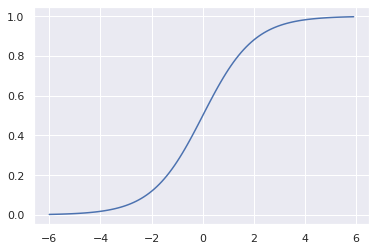

In [12]:
plt.plot(x,y)

In [47]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

data['ny'] = data['N'] - data['y']  # 発芽能力の無い種子数のカラム ny を追加
model1 = smf.glm(formula='y + ny ~ x + f', data=data, family=sm.families.Binomial()).fit(disp=0)
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            ['y', 'ny']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -133.11
Date:                Sun, 03 Oct 2021   Deviance:                       123.03
Time:                        13:07:40   Pearson chi2:                     109.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.5361      1.414    -13.818      0.000     -22.307     -16.765
f[T.T]         2.0215      0.231      8.740      0.000       1.568       2.475
x              1.9524      0.139     14.059      0.000       1.680       2.225
==============================================================================
"""

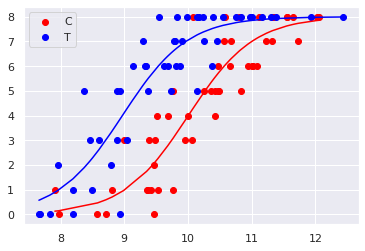

In [48]:
#肥料なし
data_C = data_C.sort_values("x")
pred_C = model1.predict(data_C.loc[:,["x","f"]])

#肥料あり
data_T = data_T.sort_values("x")
pred_T = model1.predict(data_T.loc[:,["x","f"]])

plt.scatter(data_C["x"],data_C["y"],color="red",label="C")
plt.plot(data_C["x"],8*pred_C,color="red")

plt.scatter(data_T["x"],data_T["y"],color="blue",label="T")
plt.plot(data_T["x"],8*pred_T,color="blue")

plt.legend()

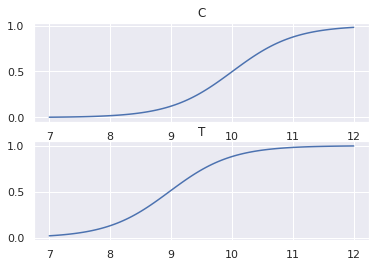

In [51]:
#predictを使わずに
b1 = model1.params[0]
b2 = model1.params[2]
b3 = model1.params[1]

x = np.linspace(7,12,100)
x_c = x*b2 + b1
z_t = x*b2 + b1 + b3
y_c = sigmoid(x_c)
y_t = sigmoid(z_t)

plt.subplot(2,1,1)
plt.plot(x,y_c)
plt.title("C")

plt.subplot(2,1,2)
plt.plot(x,y_t)
plt.title("T")

plt.show()

In [52]:
#StepAICはないので自作関数で網羅的に探索

formula_list = ["y+(N-y) ~1","y+(N-y)~f","y+(N-y)~x","y+(N-y)~x+f"]

for formula in formula_list:
  model = smf.glm(formula,data=data,family=sm.families.Binomial())
  result = model.fit()
  print(formula,-2*(result.llf-(result.df_model+1)))

y+(N-y) ~1 412.39456801224645
y+(N-y)~f 412.46513133917347
y+(N-y)~x 353.92891994781877
y+(N-y)~x+f 341.005407191829


In [54]:
import urllib.request
from io import StringIO

url = "https://raw.githubusercontent.com/takitsuba/midoribon/master/Chap6/data4b.csv"

#csvを読み込む関数
def read_csv(url):
    print(url)
    res = urllib.request.urlopen(url)
    res = res.read().decode("utf-8")
    df = pd.read_csv(StringIO( res) )
    return df

df = read_csv(url)

https://raw.githubusercontent.com/takitsuba/midoribon/master/Chap6/data4b.csv


In [59]:
df

,y,x,A
0,57,0.68,10.3
1,64,0.27,15.6
2,49,0.46,10.0
3,64,0.45,14.9
4,82,0.74,14.0
...,...,...,...
95,57,0.76,9.8
96,49,0.17,12.5
97,95,0.98,11.4
98,27,0.54,5.4


In [61]:
#offset項で予測
model = smf.glm("y~x",offset=np.log(df["A"]),data=df,family=sm.families.Poisson())

In [62]:
result = model.fit(disp=0)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -323.17
Date:                Sun, 03 Oct 2021   Deviance:                       81.608
Time:                        13:51:19   Pearson chi2:                     81.5
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9731      0.045     21.600      0.000       0.885       1.061
x              1.0383      0.078     13.364      0.000       0.886       1.191
==============================================================================
"""

Text(0, 0.5, 'y')

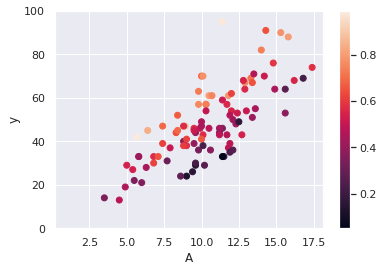

In [64]:
#可視化
plt.scatter(df["A"],df["y"],c=df["x"])
plt.colorbar()

plt.xlim(0.18)
plt.ylim(0,100)

plt.xlabel("A")
plt.ylabel("y")

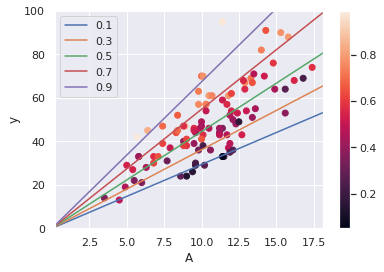

In [69]:
#モデルで予測されたものを反映した可視化
df_predict = pd.DataFrame()
df_predict["x"] = 0
df_predict["A"] = np.arange(0.1,20,0.1)
x_list = [0.1,0.3,0.5,0.7,0.9]

plt.scatter(df["A"],df["y"],c=df["x"])
plt.colorbar()
plt.xlim(0.18)
plt.ylim(0,100)

plt.xlabel("A")
plt.ylabel("y")

for x in x_list:
  df_predict["x"] = x #一度Aと対応させるようにｘを代入
  plt.plot(df_predict["A"],result.predict(df_predict,offset=np.log(df_predict["A"])),label=x)
  plt.legend()


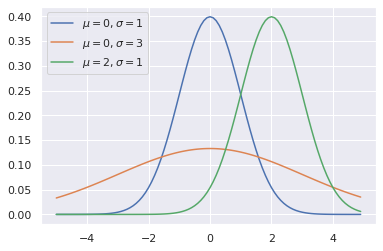

In [70]:
#確率密度の図示
import scipy.stats as sct

y = np.arange(-5,5,0.1)
plt.plot(pd.Series(sct.norm.pdf(y, loc=0, scale=1), index=y), label=r'$\mu=0, \sigma=1$')
plt.plot(pd.Series(sct.norm.pdf(y, loc=0, scale=3), index=y), label=r'$\mu=0, \sigma=3$')
plt.plot(pd.Series(sct.norm.pdf(y, loc=2, scale=1), index=y), label=r'$\mu=2, \sigma=1$')
plt.legend()

In [71]:
#確率の計算をするには、平均μ、標準偏差を指定し、調べたい確率の範囲を決める
def menseki(begin,end,loc,scale):
  menseki_begin = sct.norm.cdf(x=begin,loc=loc,scale=scale)
  menseki_end = sct.norm.cdf(x=end,loc=loc,scale=scale)
  return menseki_end - menseki_begin

In [72]:
menseki(1.2,1.8,0,1)

0.07913935110878245

In [73]:
%cd /content/drive/My Drive/Colabdata/

[Errno 2] No such file or directory: '/content/drive/My Drive/Colabdata/'
/content


In [74]:
!git clone https://github.com/reponame.git

Cloning into 'reponame'...
remote: Not Found
fatal: repository 'https://github.com/reponame.git/' not found


In [75]:
!git config --global user.email "ainj_hamn526@yahoo.co.jp"

In [76]:
!git config --global user.name "beezow526"

In [77]:
!git add file.py

fatal: not a git repository (or any of the parent directories): .git


In [78]:
!git commit -m "Added new file."

fatal: not a git repository (or any of the parent directories): .git


In [79]:
!git push origin master

fatal: not a git repository (or any of the parent directories): .git


In [80]:
git branch <branchname>

SyntaxError: ignored